In [1]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

In [2]:
n = 5
N = n*n                    # número de partículas

rho = 0.1                 # densidade de partículas
box_size = np.sqrt(N/rho)  # dimensão linear da caixa
temperature = 1.05

r_c = 2.5                  # raio de corte da interação de Lennard-Jones
r2_c = r_c*r_c

r_v = 2.5                   # raio da lista de Verlet
r2_v = r_v*r_v   
print(box_size)

9.486832980505138


In [3]:
@njit
def distance(x1, y1, x2, y2, box_size):
    x_ij = x1 - x2
    y_ij = y1 - y2
            
    # corrige a distância entre partículas segundo a condição de contorno (condições de contorno periódicas)
    x_ij = x_ij - box_size*np.rint(x_ij/box_size)
    y_ij = y_ij - box_size*np.rint(y_ij/box_size)
    dist = x_ij*x_ij + y_ij*y_ij
    dist = np.sqrt(dist)
    return x_ij, y_ij, dist

In [4]:
@njit
def create_initial(N, box_size,temperature = 1.0):
    n = int(np.sqrt(N))
    
    x = np.zeros(N)
    y = np.zeros(N)
    
    v_x = np.zeros(N)
    v_y = np.zeros(N)
    
    d = box_size/n
    
    count = 0
    for i in range(n):
        for j in range(n):
            
            # distribui as partículas numa rede quadrada centrada  
            x[count] = ( d * i ) + d/2 - ( box_size/2 )
            y[count] = ( d * j ) + d/2 - ( box_size/2 ) 
            
            # escolhe a velocidade uniformemente num circulo unitário 
            phi = np.random.uniform(0,2*np.pi)
            v_x[count] = np.cos(phi)
            v_y[count] = np.sin(phi)
            count += 1
    
    # normaliza as velocidades de acordo com o teorema da equipartição da energia  
    prov=np.sqrt((2.0-2.0/N)*temperature)  

    v_x=v_x*prov  
    v_y=v_y*prov  

    # zera o momento total das partículas  
    prov=np.sum(v_x)  
    v_x=v_x-prov/N  
    prov=np.sum(v_y)  
    v_y=v_y-prov/N  

   
    return x, y, v_x, v_y

In [5]:
@njit
def verlet_list(x, y, r2_v, box_size):
    N = len(x)
    
    n_viz = np.zeros(N, dtype=np.int64)             # número de vizinhos por partícula
    viz = np.full(N*(N-1), -1, dtype=np.int64)      # os n_viz[i] vizinhos listados
    
    count = 0
    for i in range(N):                              # loop sobre todas as partículas
        for j in range(N):                          # loop sobre todos os possíveis vizinhos
            x_ij = x[i] - x[j]
            y_ij = y[i] - y[j]
            
            # corrige a distância entre partículas segundo a condição de contorno (condições de contorno periódicas
            x_ij = x_ij - box_size*np.rint(x_ij/box_size)
            y_ij = y_ij - box_size*np.rint(y_ij/box_size)
            
            r2_ij = x_ij*x_ij + y_ij*y_ij   # quadrado da distância entre as partículas
    
            if r2_ij <= r2_v and r2_ij != 0: 
                viz[count] = j
                count += 1
                n_viz[i] += 1
    
    viz_2 = np.empty(count, dtype=np.int64)
    for i in range(count):
        viz_2[i] = viz[i]
    
    return n_viz, viz_2

In [ ]:
x,y,vx,vy = create_initial(N,box_size,temperature)
plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(vx,vy)
plt.show()

In [ ]:
%time _ = verlet_list(x,y,r2_c,box_size) 

In [32]:
n_viz, viz = verlet_list(x,y,r2_v,box_size)
print(n_viz)
print(viz)

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20]
[ 1  2  3  4  5  6  7  8  9 10 11 14 15 16 19 20 21 22 23 24  0  2  3  4
  5  6  7  8  9 10 11 12 15 16 17 20 21 22 23 24  0  1  3  4  5  6  7  8
  9 11 12 13 16 17 18 20 21 22 23 24  0  1  2  4  5  6  7  8  9 12 13 14
 17 18 19 20 21 22 23 24  0  1  2  3  5  6  7  8  9 10 13 14 15 18 19 20
 21 22 23 24  0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 19 20 21 24
  0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 20 21 22  0  1  2  3
  4  5  6  8  9 10 11 12 13 14 16 17 18 21 22 23  0  1  2  3  4  5  6  7
  9 10 11 12 13 14 17 18 19 22 23 24  0  1  2  3  4  5  6  7  8 10 11 12
 13 14 15 18 19 20 23 24  0  1  4  5  6  7  8  9 11 12 13 14 15 16 17 18
 19 20 21 24  0  1  2  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22
  1  2  3  5  6  7  8  9 10 11 13 14 15 16 17 18 19 21 22 23  2  3  4  5
  6  7  8  9 10 11 12 14 15 16 17 18 19 22 23 24  0  3  4  5  6  7  8  9
 10 11 12 13 15 16 17 18 19 20 23 24  0  1  4 

In [27]:
@njit
def lennard_jones(dist,r_c = 2.5):
    epsilon = 0.1
    sigma = 1
    if dist <= r_c:
        res = (48*epsilon/(sigma*sigma)) * (np.power(sigma/dist,14) - 1/2 * np.power(sigma/dist,8))
    else:
        res = 0
    return res

In [41]:
@njit
def calculate_force(x, y, i, j, box_size, r_c = 2.5):
    # calcula a força que j faz em i
    N = len(x)
    
    force = np.zeros(2, dtype = np.float64)
    
    x_ij, y_ij, dist = distance(x[i],y[i],x[j],y[j],box_size)
    #print(dist)
    force_mod = lennard_jones(dist,r_c)
    
    force[0] = force_mod * x_ij  
    force[1] = force_mod * y_ij
    
    return force

In [31]:
@njit
def calculate_energia(x,y,vx,vy, r_c = 2.5):
    N = len(x)
    
    energia = 0
    epsilon = 1
    sigma = 1
    
    for i in range(N):
        energia += 1/2 * (vx[i]*vx[i] + vy[i]*vy[i]) 
        for j in range(i+1,N):
            x_ij, y_ij, dist = distance(x[i],y[i],x[j],y[j],box_size)
            if dist <= r_c:
                energia += 4*epsilon*((np.power(sigma/dist,12) - np.power(sigma/dist,6)) - (np.power(sigma/r_c,12) - np.power(sigma/r_c,6)))
            else:
                energia += 0
                
    return energia

In [32]:
@njit
def simulate(x, y, vx, vy, n_viz, viz, forces, box_sixe, passo, dt = 0.001, r2_v = 2.5*2.5):
    N = len(x)

    energia = 0
    
    # calcula a lista de vizinhos (condição: à cada dez passos (tem que mudar segundo a teoria))
    if passo%1 == 0:
        n_viz, viz = verlet_list(x, y, r2_v, box_size)
        forces = np.zeros((len(viz),2))

    # calcula a força entre as partículas
    for i in range(N):
        for j in range(int(sum(n_viz[:i])),int(sum(n_viz[:i+1]))):
            forces[i] += calculate_force(x,y,i,viz[j],box_size)
            
    # evolui as posições e velocidades

    # evolui os valores das velocidades
    for i in range(N):
        vx[i] = vx[i] + 1/2 * forces[i][0]*dt
        vy[i] = vy[i] + 1/2 * forces[i][1]*dt
    # evolui os valores das posições
    for i in range(N):
        x[i] = x[i] + vx[i]*dt
        y[i] = y[i] + vy[i]*dt

    # calcula a força entre as partículas
    for i in range(N):
        for j in range(int(sum(n_viz[:i])),int(sum(n_viz[:i+1]))):
            forces[i] += calculate_force(x,y,i,viz[j],box_size)

    # evolui os valores das velocidades
    for i in range(N):
        vx[i] = vx[i] + 1/2 * forces[i][0]*dt
        vy[i] = vy[i] + 1/2 * forces[i][1]*dt
        
    energia += calculate_energia(x,y,vx,vy)
    
    return x, y, vx, vy, n_viz, viz, forces, energia

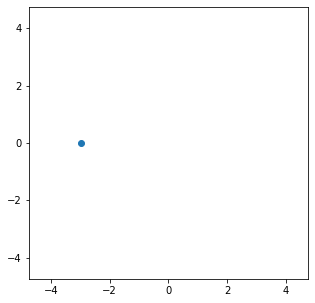

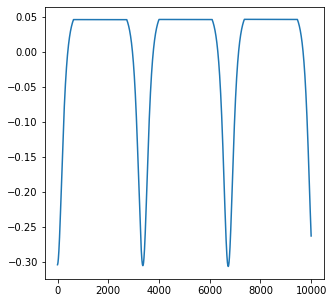

In [40]:
passos = 10000
dt = 0.005

#x,y,vx,vy = create_initial(N,box_size,temperature)
x = [1.5,0.0]
y = [0.0, 0.0]
vx = [0.01,0.0]
vy= [0.0,0.0]
energias = np.zeros(passos)

energias[0] = calculate_energia(x,y,vx,vy)

n_viz, viz = verlet_list(x, y, r2_v, box_size)
forces = np.zeros((len(viz),2))

for i in range(N):
    for j in range(int(sum(n_viz[:i])),int(sum(n_viz[:i+1]))):
        forces[i] += calculate_force(x,y,i,viz[j],box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    energias[i] = energia
    #print(x,y)
    if i%100 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

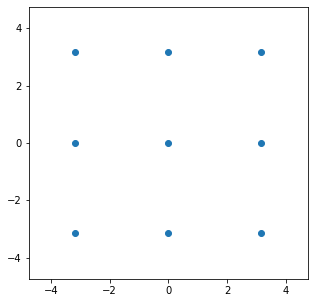

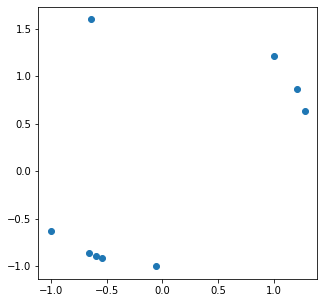

In [11]:
x,y,vx,vy = create_initial(N,box_size,temperature)
plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()
plt.figure(figsize=(5,5))
plt.scatter(vx,vy)
plt.show()

In [102]:
for i in range(10000):
    if i%10 == 0:
        n_viz, viz = verlet_list(x, y, r2_v, box_size)
    x,y,vx,vy = envolver(x, y, vx, vy, n_viz, viz, box_size)
    if i%100 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2-1,box_size/2+1)
        plt.ylim(-box_size/2-1,box_size/2+1)
        plt.scatter(x,y)
        plt.show()
        plt.figure(figsize=(5,5))
        plt.scatter(vx,vy)
        plt.show()
        display.clear_output(wait=True)

NameError: name 'envolver' is not defined

In [28]:
from IPython import display
import time